**Outline**

**Import Data**
<br>**EDA**
<br>**Model 1**
<br>**1. Random Forest**: Gridsearch, Model Prediction, Model Validation
<br>**2. XGBoost**: Gridsearch, Model Prediction, Model Validation
<br>**3. Random Forest Model Deployment on Test Data**

<br>**Model 2**
<br>**1. Random Forest**: Gridsearch, Model Prediction, Model Validation
<br>**2. XGBoost**: Gridsearch, Model Prediction, Model Validation
<br>**3. XGBoost Model Deployment on Test Data**


In [1]:
import pandas as pd
import joblib 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report 

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split


from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from pathlib import Path


# Import data

In [2]:
file_path = Path("/Users/lorelablaka/Documents/Flatiron/phase-5/capstone/collect_clean")
data_viz = joblib.load(f"{file_path}/data2_viz.pkl")

data = joblib.load(f"{file_path}/data2.pkl")

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3848 entries, 1 to 6433
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ticker        3848 non-null   object 
 1   sector        3848 non-null   object 
 2   vc_dummy      3848 non-null   object 
 3   rollup        3848 non-null   object 
 4   dual          3848 non-null   object 
 5   internet      3848 non-null   object 
 6   years_to_ipo  3848 non-null   int64  
 7   day_1_%       3848 non-null   float64
 8   month_7_%     1323 non-null   float64
 9   successful    3848 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 330.7+ KB


# EDA

**EDA of Dependent Variable**

In [3]:
data['successful'].value_counts()

0    2704
1    1144
Name: successful, dtype: int64

In [4]:
data_viz[data_viz['sector']=='Conglomerates']

,ticker,trade_date,ipo_year,day_1_%,month_7_%,sector,vc_dummy,rollup,dual,internet,...,ebitda_margins,profit_margins,gross_margins,revenue_growth,total_revenue,operating_cashflow,profitable,valuable,success,successful
4490,PRLX,2010-03-10,2010,0.246575,-0.479167,Conglomerates,0,0,0,0,...,0.0,0.0,0.86915,50.369,128600.0,-2945573.0,1,1,2,1


**Gross Margin by sector**

<BarContainer object of 13 artists>

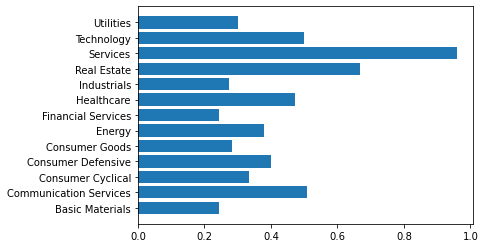

In [5]:
data_viz_margin = data_viz.groupby('sector').aggregate({'gross_margins':'median'})
data_viz_margin.reset_index(inplace=True)
data_viz_margin = data_viz_margin[(data_viz_margin['gross_margins']>0)
                                 &( data_viz_margin['sector']!= 'Conglomerates')]



x = data_viz_margin['sector']
height = data_viz_margin['gross_margins']

plt.barh(x,height)
 

**Enterprise Value to Revenue by sector**

<BarContainer object of 12 artists>

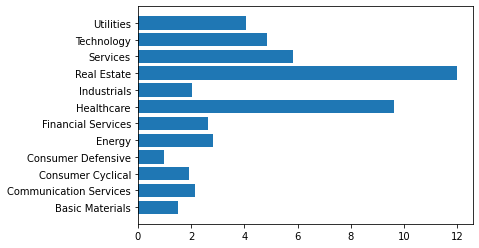

In [6]:
data_viz_evr = data_viz.groupby('sector').aggregate({'enterprise_to_revenue':'median'})
data_viz_evr.reset_index(inplace=True)
data_viz_evr = data_viz_evr[(data_viz_evr['enterprise_to_revenue']>0)
                                 &( data_viz_evr['sector']!= 'Conglomerates')]

x = data_viz_evr['sector']
height = data_viz_evr['enterprise_to_revenue']

plt.barh(x,height)


**# of IPOs per year** (in this dataset)

<AxesSubplot:xlabel='ipo_year'>

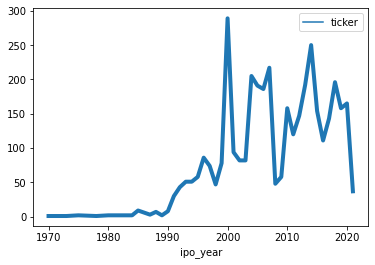

In [7]:
data_viz_return = data_viz.groupby('ipo_year').aggregate({'ticker':'count'})
data_viz_return = data_viz.groupby('ipo_year').aggregate({'ticker':'count'})


 
fig, ax = plt.subplots()
sns.lineplot(data=data_viz_return, linewidth=4)


**Relationship b.w Month 7 Returns vs first day pop** is weak (although somewhat positive)

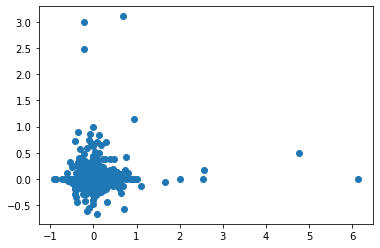

In [8]:
data_viz = data_viz[(data_viz['month_7_%']<10)
                   & (data_viz['day_1_%']<100)]
    
    
x = data_viz['month_7_%']
y = data_viz['day_1_%']

plt.scatter(x,y)
 
fig.set_size_inches(20, 20)




**Successful companies by sector**
> The horizontal bar graph attempts to validate our definition of success by making sure profitable sectors such as technology actually rank as most successful. Which they do as we can see below. 

<BarContainer object of 13 artists>

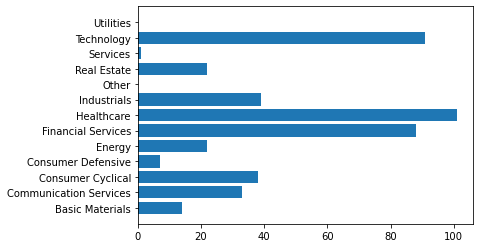

In [9]:
data_viz_evr = data_viz.groupby('sector').aggregate({'successful':'sum'})
data_viz_evr.reset_index(inplace=True)
data_viz_evr = data_viz_evr[( data_viz_evr['sector']!= 'Conglomerates')]
x = data_viz_evr['sector']
height = data_viz_evr['successful']

plt.barh(x,height)
 


# Train Test Split

In [10]:
x_feats = ['sector',
           'day_1_%', 
           'vc_dummy', 
           'rollup', 
           'dual', 
           'internet',
           'years_to_ipo'
           ]

  

X = pd.get_dummies(data[x_feats], drop_first=True)
y = data['successful'].astype(int)
X.head()

,day_1_%,years_to_ipo,sector_Communication Services,sector_Conglomerates,sector_Consumer Cyclical,sector_Consumer Defensive,sector_Consumer Goods,sector_Energy,sector_Financial Services,sector_Healthcare,...,sector_Real Estate,sector_Services,sector_Technology,sector_Utilities,vc_dummy_1,vc_dummy_2,rollup_1,dual_1,dual_2,internet_1
1,-0.032967,50,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.324324,13,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,0.001200,42,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,-0.167247,98,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
12,-0.043988,23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=.3)

# Random Forest

In [12]:
rf = RandomForestClassifier()

grid = {'n_estimators': [25, 50, 100], 
        'max_depth' : [10, 15, 20], 
        'min_samples_leaf' : [3, 6, 9]} 
 
gridsearch = GridSearchCV(rf,grid,cv = 3, return_train_score=True)

gridsearch.fit(X_train, y_train) 



 

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 15, 20],
                         'min_samples_leaf': [3, 6, 9],
                         'n_estimators': [25, 50, 100]},
             return_train_score=True)

In [13]:

print(gridsearch.best_params_)

{'max_depth': 15, 'min_samples_leaf': 6, 'n_estimators': 25}


In [14]:

# define the model
ran_for = RandomForestClassifier(n_estimators = 25,
                              max_depth = 15, 
                              min_samples_leaf = 9)

# fit the model
ran_for.fit(X_train, y_train)
y_hat_train = ran_for.predict(X_train)

**Model 1 RF Evaluation**

In [15]:
acc = accuracy_score(y_train,y_hat_train)
macro_precision_score=precision_score(y_train, y_hat_train, average='macro')
micro_precision_score=precision_score(y_train , y_hat_train, average='micro')
macro_recall_score=recall_score(y_train, y_hat_train, average='macro')
micro_recall_score=recall_score(y_train, y_hat_train, average='micro')

print('Accuracy Score: {}'.format(acc))
print('Macro Precision Score: {}'.format(macro_precision_score))
print('Micro Precision Score: {}'.format(micro_precision_score))
print('Macro Recall Score: {}'.format(macro_recall_score))
print('Micro Recall Score: {}'.format(micro_recall_score))

Accuracy Score: 0.8321574452283699
Macro Precision Score: 0.8099421972267895
Micro Precision Score: 0.8321574452283699
Macro Recall Score: 0.7723520866349709
Micro Recall Score: 0.8321574452283699


In [16]:
scoring = ['precision_macro', 'precision_micro','accuracy']
scores = cross_validate(ran_for, X, y, scoring=scoring)

precision_macro_list = list(scores['test_precision_macro'])
precision_macro_avg = sum(precision_macro_list)/len(precision_macro_list)


precision_micro_list = list(scores['test_precision_micro'])
precision_micro_avg = sum(precision_micro_list)/len(precision_micro_list)


accuracy_list = list(scores['test_accuracy'])
accuracy_avg = sum(accuracy_list)/len(accuracy_list)

print('Macro Precision Score: {}'.format(precision_macro_avg))
print('Micro Precision Score: {}'.format(precision_micro_avg))
print('Accuracy Score: {}'.format(accuracy_avg))

Macro Precision Score: 0.7715524582686403
Micro Precision Score: 0.8045780487392971
Accuracy Score: 0.8045780487392971


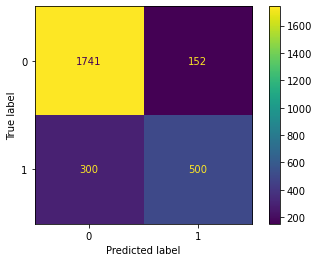

In [17]:
rf_matrix = plot_confusion_matrix(ran_for,X_train, y_train)

# XGBoost

In [18]:
# We ran the following GridSearch for XGBClassifier to find the optimal hyperparameter values.

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric ='mlogloss')

grid = {'max_depth': [6, 12, 20], 
        'min_child_weight' : [.5, 1], 
        'reg_alpha': [0,30],
       'gamma': [5,10,15]} 

 
gridsearch = GridSearchCV(xgb,grid,cv = 3, return_train_score=True)

gridsearch.fit(X_train, y_train) 


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=N

In [19]:
print(gridsearch.best_params_)

{'gamma': 5, 'max_depth': 6, 'min_child_weight': 0.5, 'reg_alpha': 30}


In [20]:
boost_model = XGBClassifier( 
    max_depth = 6,
    min_child_weight = 0.5,
    gamma = 5,
    eval_metric='mlogloss',
    use_label_encoder=False
)


boost_model.fit(X_train, y_train)
print("fit model")
    
y_hat_train = boost_model.predict(X_train)
print("predicted on model")

fit model
predicted on model


**Model 1 XGB Evaluation**

In [21]:
acc = accuracy_score(y_train,y_hat_train)
macro_precision_score=precision_score(y_train, y_hat_train, average='macro')
micro_precision_score=precision_score(y_train , y_hat_train, average='micro')
macro_recall_score=recall_score(y_train, y_hat_train, average='macro')
micro_recall_score=recall_score(y_train, y_hat_train, average='micro')

print('Accuracy Score: {}'.format(acc))
print('Macro Precision Score: {}'.format(macro_precision_score))
print('Micro Precision Score: {}'.format(micro_precision_score))
print('Macro Recall Score: {}'.format(macro_recall_score))
print('Micro Recall Score: {}'.format(micro_recall_score))

Accuracy Score: 0.831043445971036
Macro Precision Score: 0.8016382814690216
Micro Precision Score: 0.831043445971036
Macro Recall Score: 0.7841901082937137
Micro Recall Score: 0.831043445971036


In [22]:
scoring = ['precision_macro', 'precision_micro','accuracy']
scores = cross_validate(boost_model, X, y, scoring=scoring)

precision_macro_list = list(scores['test_precision_macro'])
precision_macro_avg = sum(precision_macro_list)/len(precision_macro_list)


precision_micro_list = list(scores['test_precision_micro'])
precision_micro_avg = sum(precision_micro_list)/len(precision_micro_list)


accuracy_list = list(scores['test_accuracy'])
accuracy_avg = sum(accuracy_list)/len(accuracy_list)

print('Macro Precision Score: {}'.format(precision_macro_avg))
print('Micro Precision Score: {}'.format(precision_micro_avg))
print('Accuracy Score: {}'.format(accuracy_avg))

Macro Precision Score: 0.7670473889235804
Micro Precision Score: 0.80119973654434
Accuracy Score: 0.80119973654434


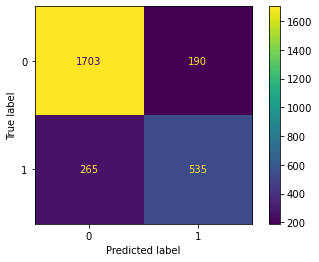

In [23]:
xgb_matrix = plot_confusion_matrix(boost_model,X_train, y_train)

# **Model 1 Deployment on Test Data**

**Random Forest** was the better performing model 

In [24]:
ran_for = RandomForestClassifier(n_estimators = 25,
                              max_depth = 15, 
                              min_samples_leaf = 9)

ran_for.fit(X_train, y_train)
print("fit model")
    


fit model


In [25]:
y_hat_test = boost_model.predict(X_test)
print("predicted on model")

predicted on model


In [26]:
acc = accuracy_score(y_test, y_hat_test)
macro_precision_score=precision_score(y_test, y_hat_test, average='macro')
micro_precision_score=precision_score(y_test, y_hat_test, average='micro')
macro_recall_score=recall_score(y_test, y_hat_test, average='macro')
micro_recall_score=recall_score(y_test, y_hat_test, average='micro')

print('Accuracy Score: {}'.format(acc))
print('Macro Precision Score: {}'.format(macro_precision_score))
print('Micro Precision Score: {}'.format(micro_precision_score))
print('Macro Recall Score: {}'.format(macro_recall_score))
print('Micro Recall Score: {}'.format(micro_recall_score))


Accuracy Score: 0.793939393939394
Macro Precision Score: 0.7541727949369346
Micro Precision Score: 0.793939393939394
Macro Recall Score: 0.7452990135635018
Micro Recall Score: 0.793939393939394


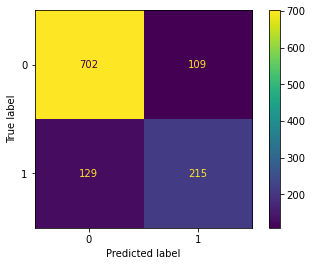

In [27]:
xgb_matrix = plot_confusion_matrix(boost_model,X_test, y_test)

# Model 2

In [28]:
data= data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1323 entries, 1 to 6433
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ticker        1323 non-null   object 
 1   sector        1323 non-null   object 
 2   vc_dummy      1323 non-null   object 
 3   rollup        1323 non-null   object 
 4   dual          1323 non-null   object 
 5   internet      1323 non-null   object 
 6   years_to_ipo  1323 non-null   int64  
 7   day_1_%       1323 non-null   float64
 8   month_7_%     1323 non-null   float64
 9   successful    1323 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 113.7+ KB


In [29]:
x_feats = ['sector',
           'day_1_%', 
           'month_7_%',
           'vc_dummy', 
           'rollup', 
           'dual', 
           'internet',
           'years_to_ipo'
           ]

  

X = pd.get_dummies(data[x_feats], drop_first=True)
y = data['successful'].astype(int)
X.head()

,day_1_%,month_7_%,years_to_ipo,sector_Communication Services,sector_Conglomerates,sector_Consumer Cyclical,sector_Consumer Defensive,sector_Energy,sector_Financial Services,sector_Healthcare,...,sector_Other,sector_Real Estate,sector_Services,sector_Technology,sector_Utilities,vc_dummy_1,vc_dummy_2,rollup_1,dual_1,internet_1
1,-0.032967,-0.009236,50,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10,-0.167247,-0.078261,98,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
12,-0.043988,-0.193333,23,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
16,0.036853,-0.056920,30,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,-0.004292,-0.124130,8,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Random Forest

In [31]:
rf = RandomForestClassifier()

grid = {'n_estimators': [25, 50, 100], 
        'max_depth' : [10, 15, 20], 
        'min_samples_leaf' : [3, 6, 9]} 
 
gridsearch = GridSearchCV(rf,grid,cv = 3, return_train_score=True)

gridsearch.fit(X_train, y_train) 

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 15, 20],
                         'min_samples_leaf': [3, 6, 9],
                         'n_estimators': [25, 50, 100]},
             return_train_score=True)

In [32]:
print(gridsearch.best_params_)

{'max_depth': 15, 'min_samples_leaf': 9, 'n_estimators': 25}


In [33]:
# random forest for feature importance on a regression problem

# define the model
ran_for = RandomForestClassifier(n_estimators = 100,
                              max_depth = 15, 
                              min_samples_leaf = 6)

# fit the model
ran_for.fit(X_train, y_train)
y_hat_train = ran_for.predict(X_train)

**Model 2 RF Evaluation**

In [34]:
acc = accuracy_score(y_train,y_hat_train)
macro_precision_score=precision_score(y_train, y_hat_train, average='macro')
micro_precision_score=precision_score(y_train , y_hat_train, average='micro')
macro_recall_score=recall_score(y_train, y_hat_train, average='macro')
micro_recall_score=recall_score(y_train, y_hat_train, average='micro')

print('Accuracy Score: {}'.format(acc))
print('Macro Precision Score: {}'.format(macro_precision_score))
print('Micro Precision Score: {}'.format(micro_precision_score))
print('Macro Recall Score: {}'.format(macro_recall_score))
print('Micro Recall Score: {}'.format(micro_recall_score))

Accuracy Score: 0.7973790322580645
Macro Precision Score: 0.789508946977818
Micro Precision Score: 0.7973790322580645
Macro Recall Score: 0.7509840716663316
Micro Recall Score: 0.7973790322580645


In [35]:
scoring = ['precision_macro', 'precision_micro','accuracy']
scores = cross_validate(ran_for, X, y, scoring=scoring)

precision_macro_list = list(scores['test_precision_macro'])
precision_macro_avg = sum(precision_macro_list)/len(precision_macro_list)


precision_micro_list = list(scores['test_precision_micro'])
precision_micro_avg = sum(precision_micro_list)/len(precision_micro_list)


accuracy_list = list(scores['test_accuracy'])
accuracy_avg = sum(accuracy_list)/len(accuracy_list)

print('Macro Precision Score: {}'.format(precision_macro_avg))
print('Micro Precision Score: {}'.format(precision_micro_avg))
print('Accuracy Score: {}'.format(accuracy_avg))

Macro Precision Score: 0.6847345237090854
Micro Precision Score: 0.7127587192681533
Accuracy Score: 0.7127587192681533


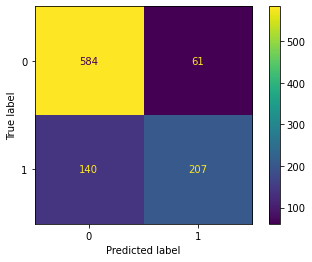

In [36]:
rf_matrix = plot_confusion_matrix(ran_for,X_train, y_train)

# XGBoost

In [37]:
# We ran the following GridSearch for XGBClassifier to find the optimal hyperparameter values.

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric ='mlogloss')

grid = {'max_depth': [6, 12, 20], 
        'min_child_weight' : [.5, 1], 
        'reg_alpha': [0,30],
       'gamma': [5,10,15]} 

 
gridsearch = GridSearchCV(xgb,grid,cv = 3, return_train_score=True)

gridsearch.fit(X_train, y_train) 

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=N

In [38]:
print(gridsearch.best_params_)

{'gamma': 5, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 0}


In [39]:
boost_model = XGBClassifier( 
    max_depth = 20,
    min_child_weight = 0.5,
    gamma = 5,
    eval_metric='mlogloss',
    use_label_encoder=False
)

boost_model.fit(X_train, y_train)
print("fit model")
    
y_hat_train = boost_model.predict(X_train)
print("predicted on model")

fit model
predicted on model


**Model 2 XGBoost Validation**

In [40]:
acc = accuracy_score(y_train,y_hat_train)
macro_precision_score=precision_score(y_train, y_hat_train, average='macro')
micro_precision_score=precision_score(y_train , y_hat_train, average='micro')
macro_recall_score=recall_score(y_train, y_hat_train, average='macro')
micro_recall_score=recall_score(y_train, y_hat_train, average='micro')

print('Accuracy Score: {}'.format(acc))
print('Macro Precision Score: {}'.format(macro_precision_score))
print('Micro Precision Score: {}'.format(micro_precision_score))
print('Macro Recall Score: {}'.format(macro_recall_score))
print('Micro Recall Score: {}'.format(micro_recall_score))

Accuracy Score: 0.7923387096774194
Macro Precision Score: 0.7776960748268307
Micro Precision Score: 0.7923387096774194
Macro Recall Score: 0.7530996581998526
Micro Recall Score: 0.7923387096774194


In [41]:
scoring = ['precision_macro', 'precision_micro','accuracy']
scores = cross_validate(boost_model, X, y, scoring=scoring)

precision_macro_list = list(scores['test_precision_macro'])
precision_macro_avg = sum(precision_macro_list)/len(precision_macro_list)


precision_micro_list = list(scores['test_precision_micro'])
precision_micro_avg = sum(precision_micro_list)/len(precision_micro_list)


accuracy_list = list(scores['test_accuracy'])
accuracy_avg = sum(accuracy_list)/len(accuracy_list)

print('Macro Precision Score: {}'.format(precision_macro_avg))
print('Micro Precision Score: {}'.format(precision_micro_avg))
print('Accuracy Score: {}'.format(accuracy_avg))

Macro Precision Score: 0.667653257756009
Micro Precision Score: 0.7021612349914236
Accuracy Score: 0.7021612349914236


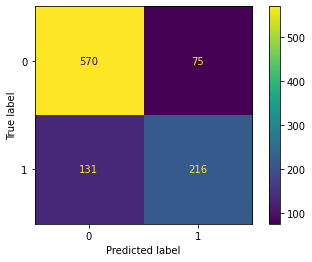

In [42]:
rgb_matrix = plot_confusion_matrix(boost_model,X_train, y_train)

# **Model 2 Deployment on Test Data**

**XGBoost** was the better performing model 

In [43]:
boost_model = XGBClassifier( 
    max_depth = 20,
    min_child_weight = 0.5,
    gamma = 5,
    eval_metric='mlogloss',
    use_label_encoder=False
)
boost_model.fit(X_train, y_train)
print("fit model")

fit model


In [44]:
y_hat_test = boost_model.predict(X_test)
print("predicted on model")

predicted on model


In [45]:
acc = accuracy_score(y_test, y_hat_test)
macro_precision_score=precision_score(y_test, y_hat_test, average='macro')
micro_precision_score=precision_score(y_test, y_hat_test, average='micro')
macro_recall_score=recall_score(y_test, y_hat_test, average='macro')
micro_recall_score=recall_score(y_test, y_hat_test, average='micro')

print('Accuracy Score: {}'.format(acc))
print('Macro Precision Score: {}'.format(macro_precision_score))
print('Micro Precision Score: {}'.format(micro_precision_score))
print('Macro Recall Score: {}'.format(macro_recall_score))
print('Micro Recall Score: {}'.format(micro_recall_score))

Accuracy Score: 0.7220543806646526
Macro Precision Score: 0.6841382301908617
Micro Precision Score: 0.7220543806646526
Macro Recall Score: 0.6571575483340188
Micro Recall Score: 0.7220543806646526
